In [83]:
import pandas as pd

date_time = "10-01-2025_02-47-57"
df = pd.read_csv("./temp/aqi_"+date_time+".csv")

print(df)

     Sensor Name           X          Y  US AQI  source
0         RENET1  121.068966  14.647362    19.0  UPCARE
1         RENET3  121.062370  14.647500    15.0  UPCARE
2         RENET4  121.064530  14.660710    32.0  UPCARE
3        BAGUIO2  120.597128  16.410988     7.0  UPCARE
4        BAGUIO1  120.595146  16.413536    66.0  UPCARE
5         RENET5  121.073771  14.657549    17.0  UPCARE
6         RENET6  121.069258  14.657391    34.0  UPCARE
7         RENET2  121.071000  14.649800    16.0  UPCARE
8   EMB_NCR_V2_1  121.057846  14.563823    76.0  UPCARE
9   EMB_NCR_V2_2  120.981000  14.592400    76.0  UPCARE
10  EMB_NCR_V2_3  121.041000  14.535600     9.0  UPCARE
11  EMB_NCR_V2_4  121.065608  14.572515    65.0  UPCARE
12        RENET7  121.073750  14.652010    14.0  UPCARE


In [86]:
# only include RENET sensors to interpolation
df = df[df['Sensor Name'].str.match(r'^RENET.*')]

path = '../congestion-emission-routing-system/aqi.csv'
df.to_csv(path, index=False)
print("DataFrame has been saved to " + path)

# df = df.drop(1)
print(df)

DataFrame has been saved to ../congestion-emission-routing-system/aqi.csv
   Sensor Name           X          Y  US AQI  source
0       RENET1  121.068966  14.647362    19.0  UPCARE
1       RENET3  121.062370  14.647500    15.0  UPCARE
2       RENET4  121.064530  14.660710    32.0  UPCARE
5       RENET5  121.073771  14.657549    17.0  UPCARE
6       RENET6  121.069258  14.657391    34.0  UPCARE
7       RENET2  121.071000  14.649800    16.0  UPCARE
12      RENET7  121.073750  14.652010    14.0  UPCARE


In [87]:
# import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# gdf = gpd.read_file('./shapefiles/Philippines_Border.shp')

# bounds = gdf.total_bounds
# Xmin = bounds[0]
# Ymin = bounds[1]
# Xmax = bounds[2]
# Ymax = bounds[3]

data = df[["X","Y","US AQI"]].to_numpy()

offset = 0.002
Xmin = min(df['X']) - offset
Xmax = max(df['X']) + offset
Ymin = min(df['Y']) - offset
Ymax = max(df['Y']) + offset

gridx = np.arange(Xmin, Xmax, 0.0001)
gridy = np.arange(Ymin, Ymax, 0.0001)

# print(gridx)
# print(gridy)

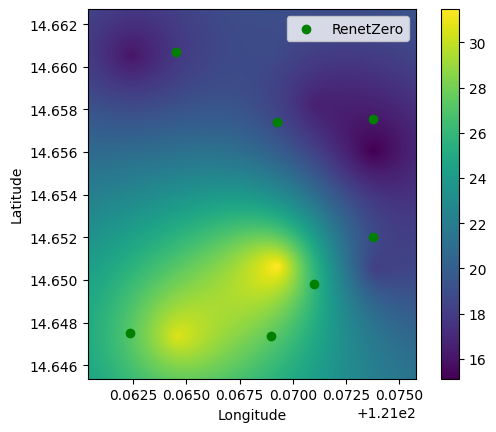

In [88]:
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

OK = OrdinaryKriging(
    data[:, 0],
    data[:, 1],
    data[:, 2],
    variogram_model="exponential",
    nlags = 6,
    verbose=False,
    enable_plotting=False,
    exact_values=True,
    enable_statistics=True,
    coordinates_type="geographic",
)

z_pred, ss = OK.execute("grid", gridx, gridy)

# kt.write_asc_grid(gridx, gridy, z, filename="output.asc")

fig, ax1 = plt.subplots()
pos = ax1.imshow(z_pred, extent=[Xmin,Xmax,Ymin,Ymax])
fig.colorbar(pos, ax=ax1)

ax1.scatter(df['X'], df['Y'], color='green', marker='o', label='RenetZero')

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()

plt.show()

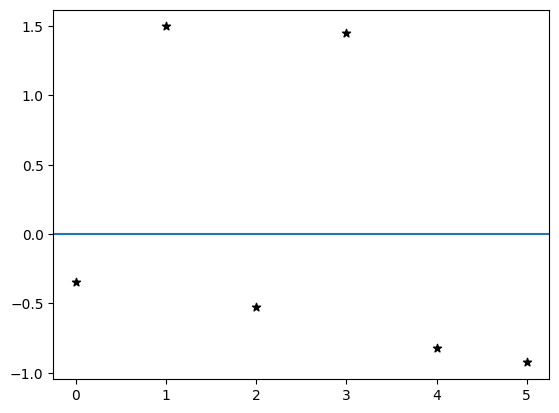

In [56]:
OK.plot_epsilon_residuals()

In [5]:
import rasterio
from rasterio.transform import from_origin

output_raster_path="./shapefiles/Philippines_Pollution_"+date_time+".tif"
pixel_size = 0.0001

transform = from_origin(gridx.min(), gridy.max(), pixel_size, pixel_size)

with rasterio.open(output_raster_path, 'w', driver='GTiff', 
            height=z_pred.shape[0], width=z_pred.shape[1],
            count=1, dtype=z_pred.dtype,
            crs='EPSG:4326', transform=transform) as dst:
    dst.write(z_pred, 1)

print(f"Raster file saved as: {output_raster_path}")

| 0.00, 0.00, 120.98|
| 0.00,-0.00, 14.66|
| 0.00, 0.00, 1.00|
Raster file saved as: ./shapefiles/Philippines_Pollution_06-12-2024_10-31-11.tif


In [6]:
import rasterio
from rasterio.transform import from_origin

# Define raster properties
date_time = "29-12-2023_21-46-49"
output_raster_path="./shapefiles/Philippines_Pollution_kriging.tif"
pixel_size = 0.001  # Resolution of the grid (adjust as necessary)

# Create the transform for the raster (affine transformation from pixel space to world coordinates)
transform = from_origin(gridx.min(), gridy.max(), pixel_size, pixel_size)

# Write the result to a GeoTIFF
with rasterio.open(output_raster_path, 'w', driver='GTiff', 
                   height=z.shape[0], width=z.shape[1],
                   count=1, dtype=z.dtype,
                   crs='EPSG:4326', transform=transform) as dst:
    dst.write(z, 1)

print(f"Raster file saved as: {output_raster_path}")

NameError: name 'z' is not defined

In [ ]:
import rasterio
import geopandas as gpd
import pandas as pd

date_time = "29-12-2023_21-46-49"
input_point_shapefile="./shapefiles/Philippines_Pollution_"+date_time+".shp"
extent_shapefile="./shapefiles/Philippines_Border.shp"
blank_filename = extent_shapefile.rsplit('.', 1)[0] + '_blank.tif'
resized_raster_name = blank_filename.rsplit('.', 1)[0] + '_resized.tif'

with rasterio.open(resized_raster_name) as baseRasterFile:
    inputPoints = gpd.read_file(input_point_shapefile)
    # obser_df stands for observation_dataframe, lat, lon, data_value for each station will be stored here.
    obser_df = pd.DataFrame()
    obser_df['station_name'] = inputPoints.iloc[:, 0]

    # create two list of indexes of station longitude, latitude in elevation raster file.
    lons, lats = baseRasterFile.index(
        [lon for lon in inputPoints.geometry.x],
        [lat for lat in inputPoints.geometry.y])
    obser_df['lon_index'] = lons
    obser_df['lat_index'] = lats
    obser_df['data_value'] = inputPoints['US AQI']

In [ ]:
pip show fiona

Name: fiona
Version: 1.9.5
Summary: Fiona reads and writes spatial data files
Home-page: 
Author: Sean Gillies
Author-email: 
License: BSD 3-Clause
Location: c:\Users\Smart I-Lab 2\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: attrs, certifi, click, click-plugins, cligj, setuptools, six
Required-by: geopandas
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\smart i-lab 2\appdata\local\programs\python\python312\lib\site-packages\eventsource-1.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
